<a href="https://www.kaggle.com/code/enesarslan8/feature-engineering-and-modeling-diabetes?scriptVersionId=102590013" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
## Importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder


pd.set_option('display.max_columns',None)
sns.set_theme(style="whitegrid")

<h1 style='text-align:center; font-family:Bahnschrift;'><b>BUSINESS PROBLEM</b></h1>

<span style='font-size:17px'>
Can we build a machine learning model to accurately predict whether or not the patients in the dataset have diabetes or not?
</span>

<h1 style='text-align:center; font-family:Bahnschrift;'><b>STORY OF THE DATASET</b></h1>
<span style='font-size:17px'>

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* Blood Pressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* DiabetesPedigreeFunction: Diabetes pedigree function
* BMI: Body mass index (weight in kg/(height in m)^2) 
* Age: Age (years)
* Outcome: Class variable (0 or 1) 268 of 768 are 1 (have diabetes), the others are 0 (dont have diabetes)
</span>

In [2]:
# Loading the dataset

df = pd.read_csv('../input/pima-indians-diabetes-database/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Changing column names to lowercase strings. (Just because i think it's easier to use)

df.columns = df.columns.str.lower()
df.columns        

Index(['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin',
       'bmi', 'diabetespedigreefunction', 'age', 'outcome'],
      dtype='object')

<h1 style='text-align:center; font-family:Bahnschrift;'><b>EXPLORATORY DATA ANALYSIS</b></h1>

In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the categorical, numerical and categorical but cardinal variables.
    Note: Categorical variables includes numerical values that have low unique values than 10.

    Parameters
    ------
        dataframe: dataframe
                Dataframe that wanted to get column types
        cat_th: int, optional
                Threshold value for the numerical but categorical values
        car_th: int, optinal
                Threshold value for the categorical but cardinal values

    Returns
    ------
        cat_cols: list
                Categorical variables
        num_cols: list
                Numeric variables
        cat_but_car: list
                Categorical but cardinal values

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [5]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
print('Categorical: {}\nNumerical: {}\nCardinal: {}'.format(cat_cols,num_cols,cat_but_car))

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1
Categorical: ['outcome']
Numerical: ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabetespedigreefunction', 'age']
Cardinal: []


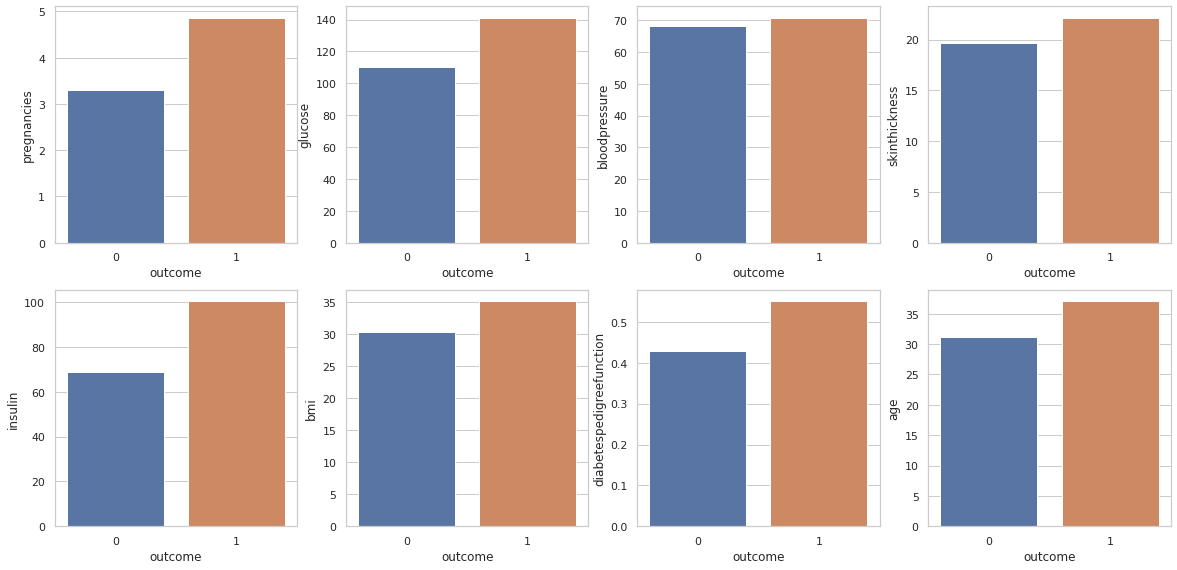

In [6]:
# Means of the variables when grouped by outcome
# You can read it like: Woman who have diabetes had more pregnancy when compared against who had less.

plt.rcParams["figure.figsize"] = (20,20)
for index ,num_col in enumerate(num_cols):
    num_group_df = df.groupby('outcome').agg({num_col:'mean'}).reset_index()
    #print(num_group_df)
    plt.subplot(4,4,index+1)
    sns.barplot(x='outcome', y=num_col,data=num_group_df)

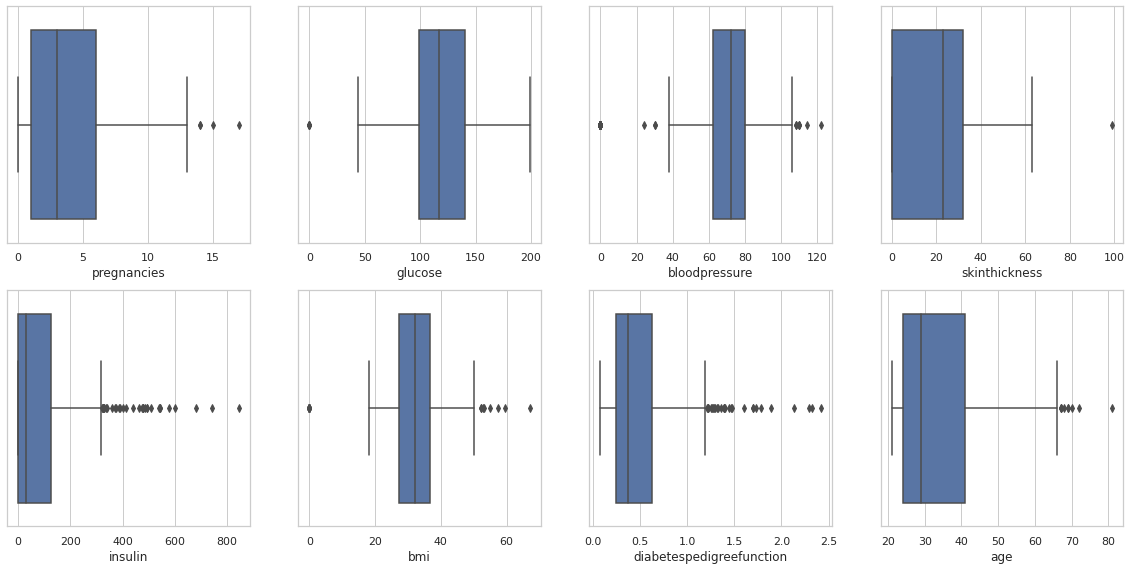

In [7]:
# Boxplot of every variables to see the summary of the outlier values

plt.rcParams["figure.figsize"] = (20,20)

for index, num_col in enumerate(num_cols):
    plt.subplot(4,4,index+1)
    sns.boxplot(x=num_col,data=df)
    
plt.show()

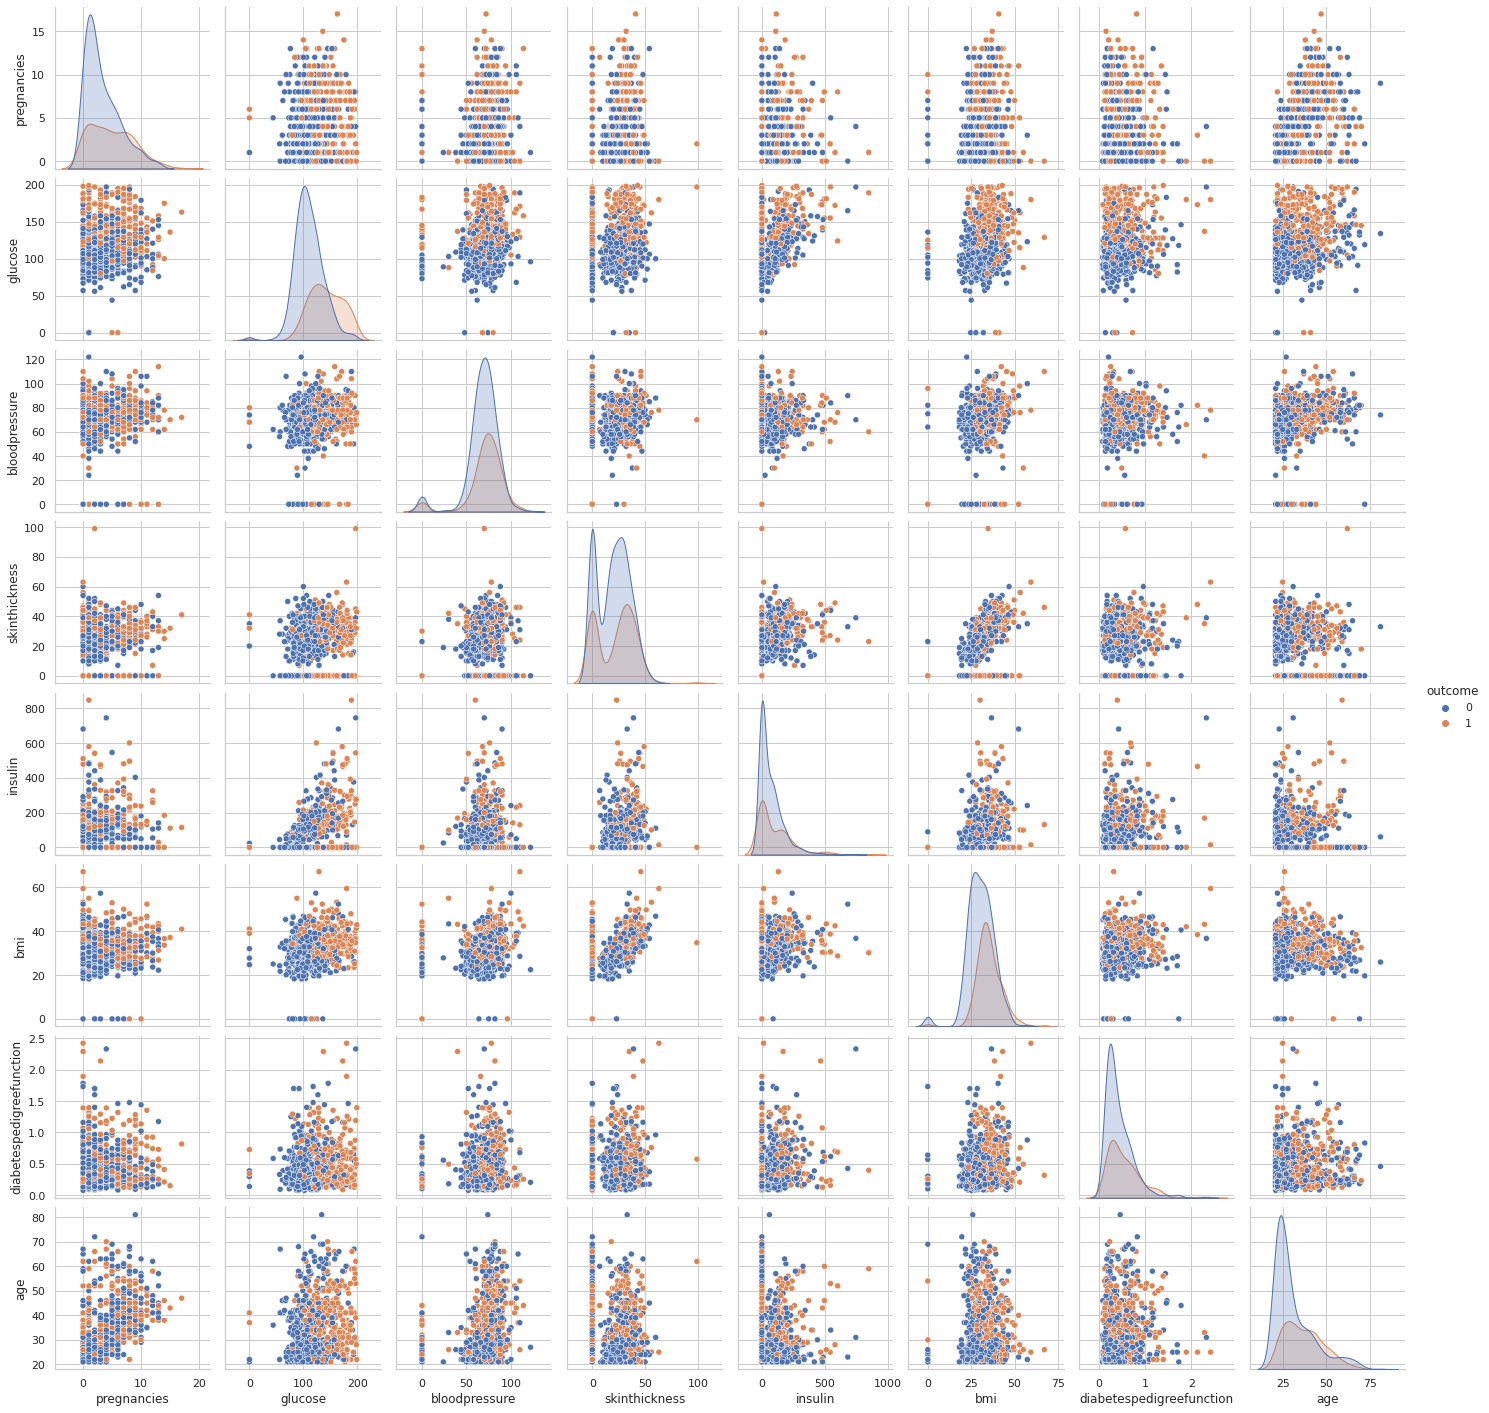

In [8]:
# Variables' effect on the target variable together

sns.pairplot(hue='outcome',data=df)
plt.show()

### Descriptive Statistics

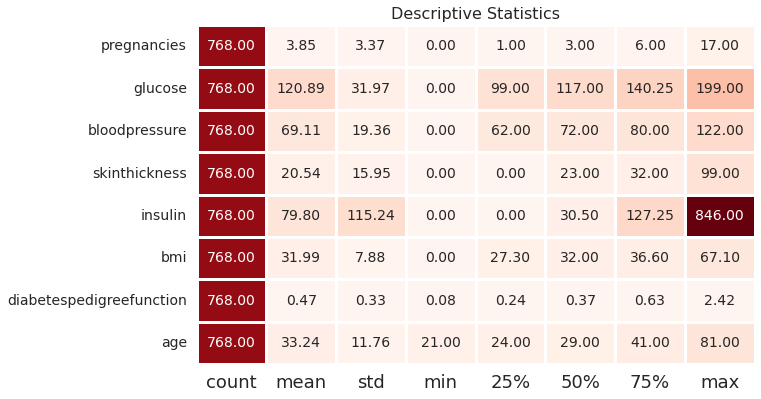

In [9]:
def desc_stats(dataframe):
    desc = dataframe.describe().T
    desc_df = pd.DataFrame(index= [col for col in dataframe.columns], 
                           columns= desc.columns,
                           data= desc)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0]*0.78))
    sns.heatmap(desc_df,
                annot=True,
                cmap = "Reds",
                fmt= '.2f',
                ax=ax,
                linewidths = 2.6,
                cbar = False,
                annot_kws={"size": 14})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 16)
    plt.show()
    
desc_stats(df[num_cols])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pregnancies               768 non-null    int64  
 1   glucose                   768 non-null    int64  
 2   bloodpressure             768 non-null    int64  
 3   skinthickness             768 non-null    int64  
 4   insulin                   768 non-null    int64  
 5   bmi                       768 non-null    float64
 6   diabetespedigreefunction  768 non-null    float64
 7   age                       768 non-null    int64  
 8   outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Missing Values

In [11]:
# Empty values by columns
df.isnull().sum()

pregnancies                 0
glucose                     0
bloodpressure               0
skinthickness               0
insulin                     0
bmi                         0
diabetespedigreefunction    0
age                         0
outcome                     0
dtype: int64

In [12]:
# There are some variables that have 0 values like insulin, bmi etc. We should change those variables' 0 values to NaN

min_zero_cols = df.columns[df.min() == 0]
cant_be_zero_cols = min_zero_cols.drop(['outcome','pregnancies'])
cant_be_zero_cols

Index(['glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi'], dtype='object')

In [13]:
df[cant_be_zero_cols] = df[cant_be_zero_cols].applymap(lambda x: np.nan if x==0 else x)
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


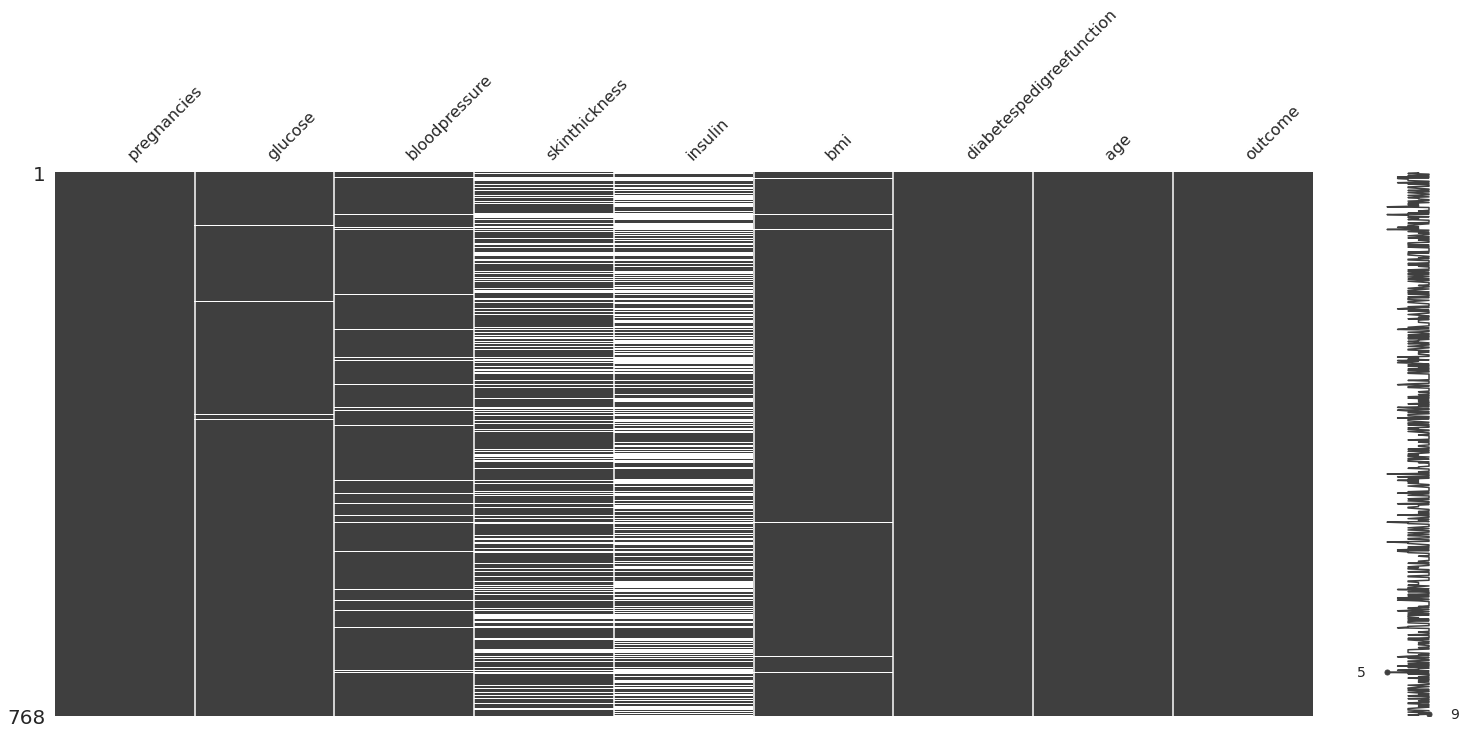

In [14]:
# Now lets see the missing values on a matrix

msno.matrix(df)
plt.show()

### Correlation

In [15]:
df.corrwith(df.outcome)

pregnancies                 0.221898
glucose                     0.494650
bloodpressure               0.170589
skinthickness               0.259491
insulin                     0.303454
bmi                         0.313680
diabetespedigreefunction    0.173844
age                         0.238356
outcome                     1.000000
dtype: float64

In [16]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
pregnancies,1.000000,0.128135,0.214178,0.100239,0.082171,0.021719,-0.033523,0.544341,0.221898
glucose,0.128135,1.000000,0.223192,0.228043,0.581186,0.232771,0.137246,0.267136,0.494650
bloodpressure,0.214178,0.223192,1.000000,0.226839,0.098272,0.289230,-0.002805,0.330107,0.170589
skinthickness,0.100239,0.228043,0.226839,1.000000,0.184888,0.648214,0.115016,0.166816,0.259491
insulin,0.082171,0.581186,0.098272,0.184888,1.000000,0.228050,0.130395,0.220261,0.303454
bmi,0.021719,0.232771,0.289230,0.648214,0.228050,1.000000,0.155382,0.025841,0.313680
diabetespedigreefunction,-0.033523,0.137246,-0.002805,0.115016,0.130395,0.155382,1.000000,0.033561,0.173844
age,0.544341,0.267136,0.330107,0.166816,0.220261,0.025841,0.033561,1.000000,0.238356
outcome,0.221898,0.494650,0.170589,0.259491,0.303454,0.313680,0.173844,0.238356,1.000000


<h1 style='text-align:center; font-family:Bahnschrift;'><b>FEATURE ENGINEERING</b></h1>

<img src='https://miro.medium.com/max/1400/1*iQ2yLnBOetnEcR4wvtKj0g.png' style='width: 1000px; height: 1000;'>

>If your data is bad, your machine learning tools are useless. -Thomas C. Redman

# Missing Values

In [17]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [18]:
missing_values_table(df)

               n_miss  ratio
insulin           374  48.70
skinthickness     227  29.56
bloodpressure      35   4.56
bmi                11   1.43
glucose             5   0.65


In [19]:
# Filling empty values with median

df = df.apply(lambda x: x.fillna(df.groupby('outcome')[x.name].transform('median')))

In [20]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


# Outliers

In [21]:
df.describe([0.01,0.05,0.25,0.5,0.75,0.90,0.95,0.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,90%,95%,99%,max
pregnancies,768.0,3.845052,3.369578,0.000,0.00000,0.00000,1.00000,3.0000,6.00000,9.0000,10.00000,13.00000,17.00
glucose,768.0,121.677083,30.464161,44.000,67.67000,80.00000,99.75000,117.0000,140.25000,167.0000,181.00000,196.00000,199.00
bloodpressure,768.0,72.389323,12.106039,24.000,44.00000,52.00000,64.00000,72.0000,80.00000,88.0000,90.00000,106.00000,122.00
skinthickness,768.0,29.089844,8.890820,7.000,10.00000,14.35000,25.00000,28.0000,32.00000,40.0000,44.00000,51.33000,99.00
insulin,768.0,141.753906,89.100847,14.000,24.34000,50.00000,102.50000,102.5000,169.50000,210.0000,293.00000,519.90000,846.00
bmi,768.0,32.434635,6.880498,18.200,19.50000,22.23500,27.50000,32.0500,36.60000,41.5000,44.39500,50.75900,67.10
diabetespedigreefunction,768.0,0.471876,0.331329,0.078,0.09468,0.14035,0.24375,0.3725,0.62625,0.8786,1.13285,1.69833,2.42
age,768.0,33.240885,11.760232,21.000,21.00000,21.00000,24.00000,29.0000,41.00000,51.0000,58.00000,67.00000,81.00
outcome,768.0,0.348958,0.476951,0.000,0.00000,0.00000,0.00000,0.0000,1.00000,1.0000,1.00000,1.00000,1.00


In [22]:
def outlier_thresholds(dataframe,colname,q1=0.05, q3=0.95):
    
    quartile1 = dataframe[colname].quantile(q1)
    quartile3 = dataframe[colname].quantile(q3)
    
    interquantile_range = quartile3 - quartile1
    
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    
    return low_limit, up_limit

In [23]:
def check_outlier(low_limit, up_limit, dataframe, colname):
    if dataframe[(dataframe[colname] > up_limit) | (dataframe[colname] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [24]:
def replace_with_thresholds(low_limit, up_limit,dataframe,colname):
    
    dataframe.loc[dataframe[colname] > up_limit,colname] = up_limit
    dataframe.loc[dataframe[colname] < low_limit,colname] = low_limit

In [25]:
# Columns that have outliers

outlier_cols = []

for col in num_cols:
    low_limit, up_limit = outlier_thresholds(df,col)
    if check_outlier(low_limit,up_limit,df,col):
        outlier_cols.append(col)

In [26]:
outlier_cols

['skinthickness', 'insulin']

In [27]:
# Changing outlier values with the thresholds that we select

for col in outlier_cols:
    low, up = outlier_thresholds(df,col)
    print(col, up)
    replace_with_thresholds(low, up, df, col)

skinthickness 88.475
insulin 657.5


# Feature Extraction

<span style='font-size:17px'>
Normal blood pressure for most adults is defined as a systolic pressure of less than 120 and a <b>diastolic pressure of less than 80</b>.<br>
</span>

In [28]:
df.bloodpressure.mean(), df.bloodpressure.median()

(72.38932291666667, 72.0)

In [29]:
df['IS_BP_NORMAL'] = df.bloodpressure <= 80
df['IS_BP_NORMAL']

0      True
1      True
2      True
3      True
4      True
       ... 
763    True
764    True
765    True
766    True
767    True
Name: IS_BP_NORMAL, Length: 768, dtype: bool

In [30]:
df.groupby('IS_BP_NORMAL').agg({'outcome':['mean','count']})

outcome      
                  mean count
IS_BP_NORMAL                
False         0.466667   165
True          0.316750   603

In [31]:
# It seems like values we created (True,False) effecting outcome value differently
# Let's measure that is it statistically meaningful or not ?

from statsmodels.stats.proportion import proportions_ztest

_, pvalue = proportions_ztest(count=[
    df.loc[df.IS_BP_NORMAL == True, 'outcome'].sum(),
    df.loc[df.IS_BP_NORMAL == False, 'outcome'].sum()
],
                             nobs= [
    df.loc[df.IS_BP_NORMAL == True, 'outcome'].shape[0],
    df.loc[df.IS_BP_NORMAL == False, 'outcome'].shape[0]
])


# Lower pvalue than 0.005 means there is statistically difference with these two values
pvalue < 0.005

True

In [32]:
df['NO_KID'] = df.pregnancies == 0
df['NO_KID']

0      False
1      False
2      False
3      False
4       True
       ...  
763    False
764    False
765    False
766    False
767    False
Name: NO_KID, Length: 768, dtype: bool

In [33]:
df.groupby('NO_KID').agg({'outcome':'mean'})

,outcome
NO_KID,
False,0.350076
True,0.342342


In [34]:
"""19-24 Age: 19-24 BMI.
25-34 Age: 20-25 BMI.
35-44 Age: 21-26 BMI.
45-54 Age: 22-27 BMI.
55-64 Age: 23-28 BMI.
65 Age or above: 24-29 BMI."""

def is_bmi_normal(age, bmi):
    
    if 19<=age<=24 and 19<=bmi<=24:
        return True
    elif 25<=age<=34 and 20<=bmi<=25:
        return True
    elif 35<=age<=44 and 21<=bmi<=26:
        return True
    elif 45<=age<=54 and 22<=bmi<=27:
        return True
    elif 55<=age<=64 and 23<=bmi<=28:
        return True
    elif 65<=age and 24<=bmi<=29:
        return True
    else:
        return False

In [35]:
df['IS_BMI_NORMAL'] = df.apply(lambda x: is_bmi_normal(x.age, x.bmi) ,axis=1)

In [36]:
df.groupby('IS_BMI_NORMAL').agg({'outcome':['count','mean']})

outcome          
                count      mean
IS_BMI_NORMAL                  
False             665  0.383459
True              103  0.126214

In [37]:
# It seems like values we created (True,False) effecting outcome value differently
# Let's measure that is it statistically meaningful or not ?


from statsmodels.stats.proportion import proportions_ztest

_, pvalue = proportions_ztest(count=[
    df.loc[df.IS_BMI_NORMAL == True, 'outcome'].sum(),
    df.loc[df.IS_BMI_NORMAL == False, 'outcome'].sum()
],
                             nobs= [
    df.loc[df.IS_BMI_NORMAL == True, 'outcome'].shape[0],
    df.loc[df.IS_BMI_NORMAL == False, 'outcome'].shape[0]
])

# Lower pvalue than 0.005 means there is statistically difference with these two values
pvalue < 0.005

True

In [38]:
df['PREG_INTERVAL']= pd.qcut(df.pregnancies,5)

In [39]:
df.groupby('PREG_INTERVAL').agg({'outcome':['count','mean']})

outcome          
                count      mean
PREG_INTERVAL                  
(-0.001, 1.0]     246  0.272358
(1.0, 2.0]        103  0.184466
(2.0, 4.0]        143  0.349650
(4.0, 7.0]        152  0.407895
(7.0, 17.0]       124  0.564516

In [40]:
df['AGE_INTERVAL'] = pd.qcut(df.age,5)

In [41]:
df.groupby('AGE_INTERVAL').agg({'outcome':['count','mean']})

outcome          
                 count      mean
AGE_INTERVAL                    
(20.999, 23.0]     173  0.132948
(23.0, 27.0]       159  0.238994
(27.0, 33.0]       142  0.429577
(33.0, 42.6]       140  0.457143
(42.6, 81.0]       154  0.532468

In [42]:
bmi_labels = ['Underweight','Healthy Weight','Overweight','Obesity']

df['BMI_Cat'] = pd.cut(df['bmi'],[0,18.5,25,30,df['bmi'].max()],labels=bmi_labels)

In [43]:
df.dtypes

pregnancies                    int64
glucose                      float64
bloodpressure                float64
skinthickness                float64
insulin                      float64
bmi                          float64
diabetespedigreefunction     float64
age                            int64
outcome                        int64
IS_BP_NORMAL                    bool
NO_KID                          bool
IS_BMI_NORMAL                   bool
PREG_INTERVAL               category
AGE_INTERVAL                category
BMI_Cat                     category
dtype: object

## Encoding

In [44]:
dff = pd.get_dummies(df,drop_first=True)
dff.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome,IS_BP_NORMAL,NO_KID,IS_BMI_NORMAL,"PREG_INTERVAL_(1.0, 2.0]","PREG_INTERVAL_(2.0, 4.0]","PREG_INTERVAL_(4.0, 7.0]","PREG_INTERVAL_(7.0, 17.0]","AGE_INTERVAL_(23.0, 27.0]","AGE_INTERVAL_(27.0, 33.0]","AGE_INTERVAL_(33.0, 42.6]","AGE_INTERVAL_(42.6, 81.0]",BMI_Cat_Healthy Weight,BMI_Cat_Overweight,BMI_Cat_Obesity
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,True,False,False,0,0,1,0,0,0,0,1,0,0,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,True,False,False,0,0,0,0,0,1,0,0,0,1,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,True,False,True,0,0,0,1,0,1,0,0,1,0,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,True,False,False,0,0,0,0,0,0,0,0,0,1,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,True,True,False,0,0,0,0,0,1,0,0,0,0,1


***

<h1 style='text-align:center; font-family:Bahnschrift;'><b>MACHINE LEARNING MODEL</b></h1>

In [45]:
scaler = MinMaxScaler()
dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
dff.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome,IS_BP_NORMAL,NO_KID,IS_BMI_NORMAL,"PREG_INTERVAL_(1.0, 2.0]","PREG_INTERVAL_(2.0, 4.0]","PREG_INTERVAL_(4.0, 7.0]","PREG_INTERVAL_(7.0, 17.0]","AGE_INTERVAL_(23.0, 27.0]","AGE_INTERVAL_(27.0, 33.0]","AGE_INTERVAL_(33.0, 42.6]","AGE_INTERVAL_(42.6, 81.0]",BMI_Cat_Healthy Weight,BMI_Cat_Overweight,BMI_Cat_Obesity
0,0.352941,0.670968,0.489796,0.343664,0.241647,0.314928,0.234415,0.483333,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.058824,0.264516,0.428571,0.270021,0.137529,0.171779,0.116567,0.166667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.470588,0.896774,0.408163,0.306843,0.241647,0.104294,0.253629,0.183333,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.058824,0.290323,0.428571,0.196379,0.124320,0.202454,0.038002,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000000,0.600000,0.163265,0.343664,0.239316,0.509202,0.943638,0.200000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [46]:
Y=dff.outcome
X=dff.drop('outcome',axis=1)

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=10)

In [48]:
(X_train.shape, Y_train.shape)

((537, 22), (537,))

In [49]:
rf_model = RandomForestClassifier(random_state=10).fit(X_train,Y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, Y_test)

0.8744588744588745

<h1 style='text-align:center; font-family:Bahnschrift;'><b>CONCLUSION</b></h1>

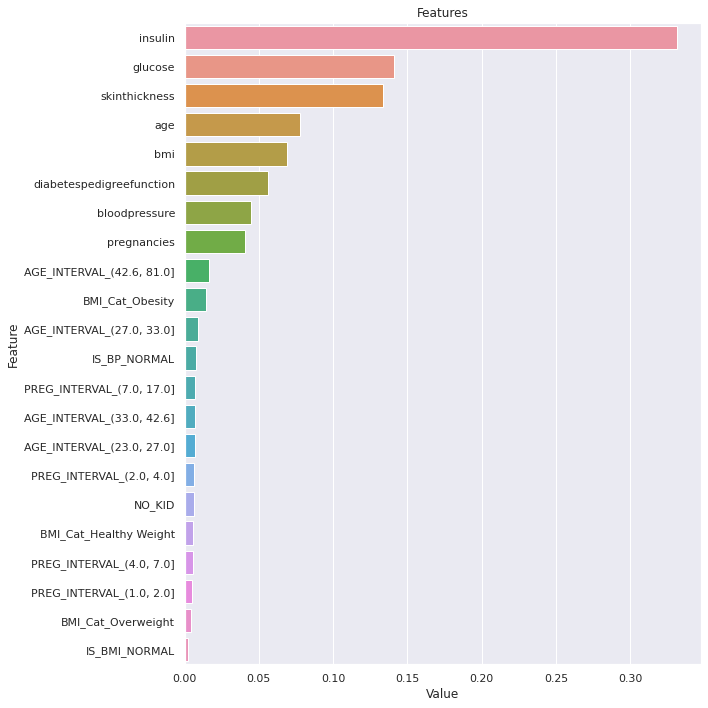

In [50]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)

In [51]:
pd.DataFrame(rf_model.feature_importances_, index= X.columns).sort_values(0,ascending=False).head()

,0
insulin,0.331342
glucose,0.141208
skinthickness,0.133807
age,0.077817
bmi,0.069274


Text(0.5, 3.5, 'Predicted label')

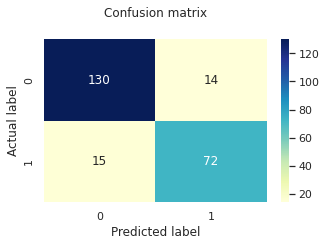

In [52]:
plt.rcParams["figure.figsize"] = (5,3)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(Y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

<h1 style='text-align:center; font-family:Bahnschrift;'><b>THANKS...</b></h1>